We start by downloading the dataset, the original dataset is from: https://www.kaggle.com/datasets/alexandredj/rock-paper-scissors-dataset

But I will download it from my google drive

In [1]:
!gdown --id 1wTJlU-gJf3KLDrSxMUk9A0MnI2YEkXp9 -O archive.zip
!unzip -q archive.zip -d RockPaperScissors
!rm archive.zip

/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1wTJlU-gJf3KLDrSxMUk9A0MnI2YEkXp9
From (redirected): https://drive.google.com/uc?id=1wTJlU-gJf3KLDrSxMUk9A0MnI2YEkXp9&confirm=t&uuid=7cb1ffc3-0555-402c-8c74-d6acfb9316af
To: /content/archive.zip
100% 386M/386M [00:03<00:00, 122MB/s]


Now we build a pipeline to transform the data and make data augmentation

In [2]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

data_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((128, 128)),

    transforms.RandomHorizontalFlip(p=0.3),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2),

    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])


Then we have to prepare the dataset, we will split into train and validation datasets 90% - 10%

In [3]:

full_dataset = datasets.ImageFolder(root="./RockPaperScissors", transform=data_transforms)

n_train_split = int(0.9 * len(full_dataset))
n_val_split = len(full_dataset) - n_train_split

train_dataset, val_dataset = random_split(full_dataset, [n_train_split, n_val_split])


train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

print(f"data {len(full_dataset)}")
print(f"Classes: {full_dataset.classes}")

data 2717
Classes: ['paper', 'rock', 'scissors']


We will visualize how the transformations affect our images

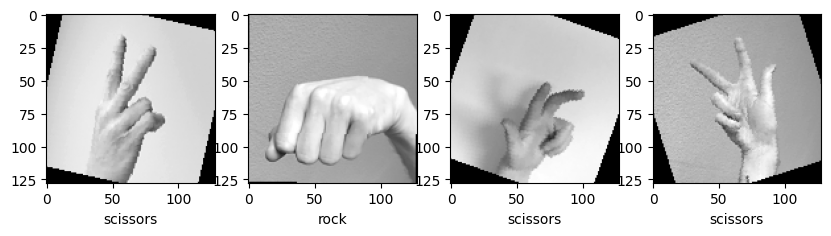

In [7]:
import matplotlib.pyplot as plt


data = next(iter(train_loader))




plt.figure(figsize=(10, 4))

images, labels = data

for i in range(4):
  plt.subplot(1, 4, i+1)
  plt.imshow(images[i].squeeze(), cmap="gray")
  plt.xlabel(full_dataset.classes[labels[i]])

plt.show()

Now we define the CNN network architecture

In [8]:
import torch.nn as nn
import torch.nn.functional as F

class RockPaperScissorsCNN(nn.Module):
  def __init__(self):
    super().__init__()

    self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
    self.bn1 = nn.BatchNorm2d(16)

    self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
    self.bn2 = nn.BatchNorm2d(32)

    self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
    self.bn3 = nn.BatchNorm2d(64)

    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    self.flatten = nn.Flatten()

    # Pooling will be aplied 3 times so dimentions will be reduce to half 3 times
    self.fc1 = nn.Linear(in_features=64 * 16 * 16, out_features=512)
    self.bn4 = nn.BatchNorm1d(512)
    self.fc2 = nn.Linear(in_features=512, out_features=3)

  def forward(self, x):
    x = self.pool(F.relu(self.bn1(self.conv1(x))))
    x = self.pool(F.relu(self.bn2(self.conv2(x))))
    x = self.pool(F.relu(self.bn3(self.conv3(x))))

    x = self.flatten(x)

    x = self.fc1(x)
    x = self.bn4(x)
    x = self.fc2(x)

    return x

Training loop

In [9]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = RockPaperScissorsCNN()
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

epochs = 15

for epoch in range(epochs):
  model.train()
  train_loss = 0
  for image, labels in train_loader:
    image, labels = image.to(device), labels.to(device)
    optimizer.zero_grad()
    logits = model(image)
    loss = criterion(logits, labels)
    loss.backward()
    optimizer.step()

    train_loss += loss.item()

  model.eval()
  eval_loss = 0
  with torch.no_grad():
    for image, labels in val_loader:
      image, labels = image.to(device), labels.to(device)
      logits = model(image)
      loss = criterion(logits, labels)
      eval_loss += loss.item()

  avg_train_loss = train_loss/len(train_loader)
  avg_val_loss = eval_loss / len(val_loader)
  print(f"Epoch {epoch+1}/{epochs} | Training loss {avg_train_loss:.4f} | Eval loss {avg_val_loss:.4f}")

Epoch 1/15 | Training loss 1.2610 | Eval loss 0.6768
Epoch 2/15 | Training loss 0.6762 | Eval loss 0.5289
Epoch 3/15 | Training loss 0.4998 | Eval loss 0.4056
Epoch 4/15 | Training loss 0.4186 | Eval loss 0.3493
Epoch 5/15 | Training loss 0.3595 | Eval loss 0.3234
Epoch 6/15 | Training loss 0.3012 | Eval loss 0.2784
Epoch 7/15 | Training loss 0.2774 | Eval loss 0.3024
Epoch 8/15 | Training loss 0.2688 | Eval loss 0.2976
Epoch 9/15 | Training loss 0.2344 | Eval loss 0.2355
Epoch 10/15 | Training loss 0.2271 | Eval loss 0.2596
Epoch 11/15 | Training loss 0.2066 | Eval loss 0.2497
Epoch 12/15 | Training loss 0.2326 | Eval loss 0.4172
Epoch 13/15 | Training loss 0.1822 | Eval loss 0.2133
Epoch 14/15 | Training loss 0.1740 | Eval loss 0.1896
Epoch 15/15 | Training loss 0.1768 | Eval loss 0.1773


Now we convert the model to onnx to run in client-side javascript

In [11]:
!pip install onnxscript onnx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 693.4/693.4 kB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.1/18.1 MB 90.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.1/133.1 kB 14.3 MB/s eta 0:00:00


In [15]:
model_name = "rock_paper_scissors.onnx"

model.to("cpu")
model.eval()

dummy_input = torch.rand(1, 1, 128, 128)

torch.onnx.export(
    model,
    dummy_input,
    model_name,
    export_params=True,
    opset_version=18,
    do_constant_folding=True,
    input_names=["input"],
    output_names=["output"],
    external_data=False
)

[torch.onnx] Obtain model graph for `RockPaperScissorsCNN([...]` with `torch.export.export(..., strict=False)`...
[torch.onnx] Obtain model graph for `RockPaperScissorsCNN([...]` with `torch.export.export(..., strict=False)`... ✅
[torch.onnx] Run decomposition...
[torch.onnx] Run decomposition... ✅
[torch.onnx] Translate the graph into ONNX...
[torch.onnx] Translate the graph into ONNX... ✅
Applied 4 of general pattern rewrite rules.


ONNXProgram(
    model=
        <
            ir_version=10,
            opset_imports={'': 18},
            producer_name='pytorch',
            producer_version='2.9.0+cu126',
            domain=None,
            model_version=None,
        >
        graph(
            name=main_graph,
            inputs=(
                %"input"<FLOAT,[1,1,128,128]>
            ),
            outputs=(
                %"output"<FLOAT,[1,3]>
            ),
            initializers=(
                %"conv1.weight"<FLOAT,[16,1,3,3]>{Tensor(...)},
                %"conv1.bias"<FLOAT,[16]>{Tensor(...)},
                %"conv2.weight"<FLOAT,[32,16,3,3]>{Tensor(...)},
                %"conv2.bias"<FLOAT,[32]>{Tensor(...)},
                %"conv3.weight"<FLOAT,[64,32,3,3]>{Tensor(...)},
                %"conv3.bias"<FLOAT,[64]>{Tensor(...)},
                %"fc1.weight"<FLOAT,[512,16384]>{Tensor(...)},
                %"fc1.bias"<FLOAT,[512]>{Tensor(...)},
                %"fc2.weight"<FLOAT,[3,512]>{T